# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Options

In [2]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)
    train_feats = [var for x in train_feats for var in train_feats[x]]

In [3]:
n_models = 10
patience = 2
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam'}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
train_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'train.hdf5', "r+"), rot_mult=8)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 32


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


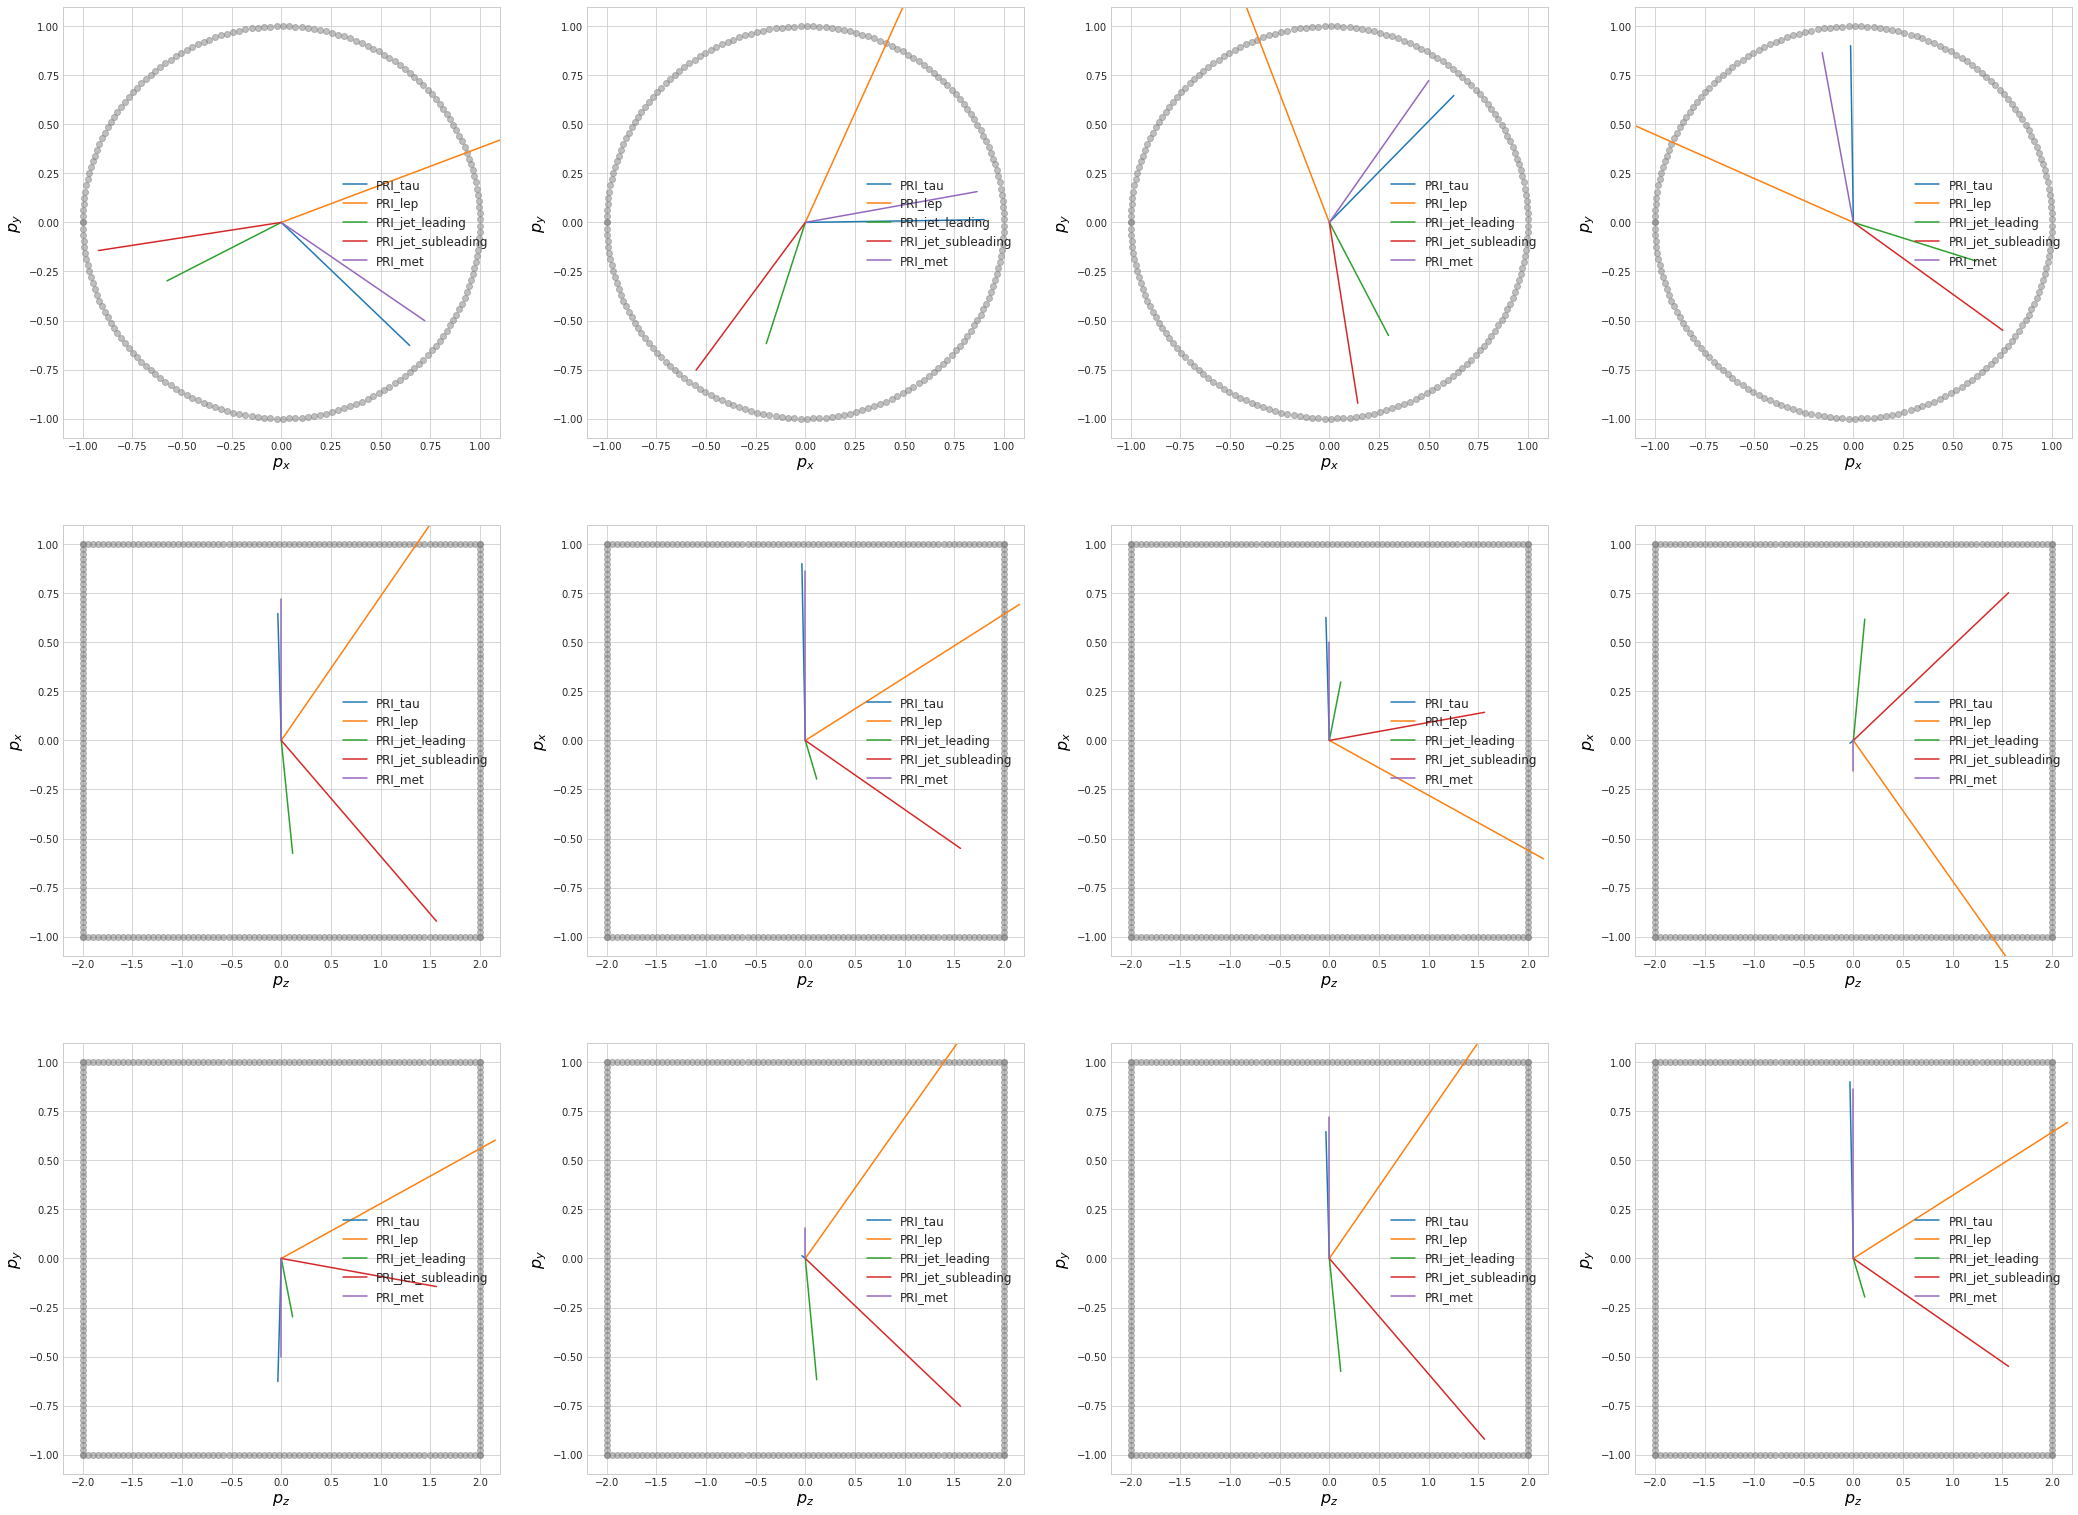

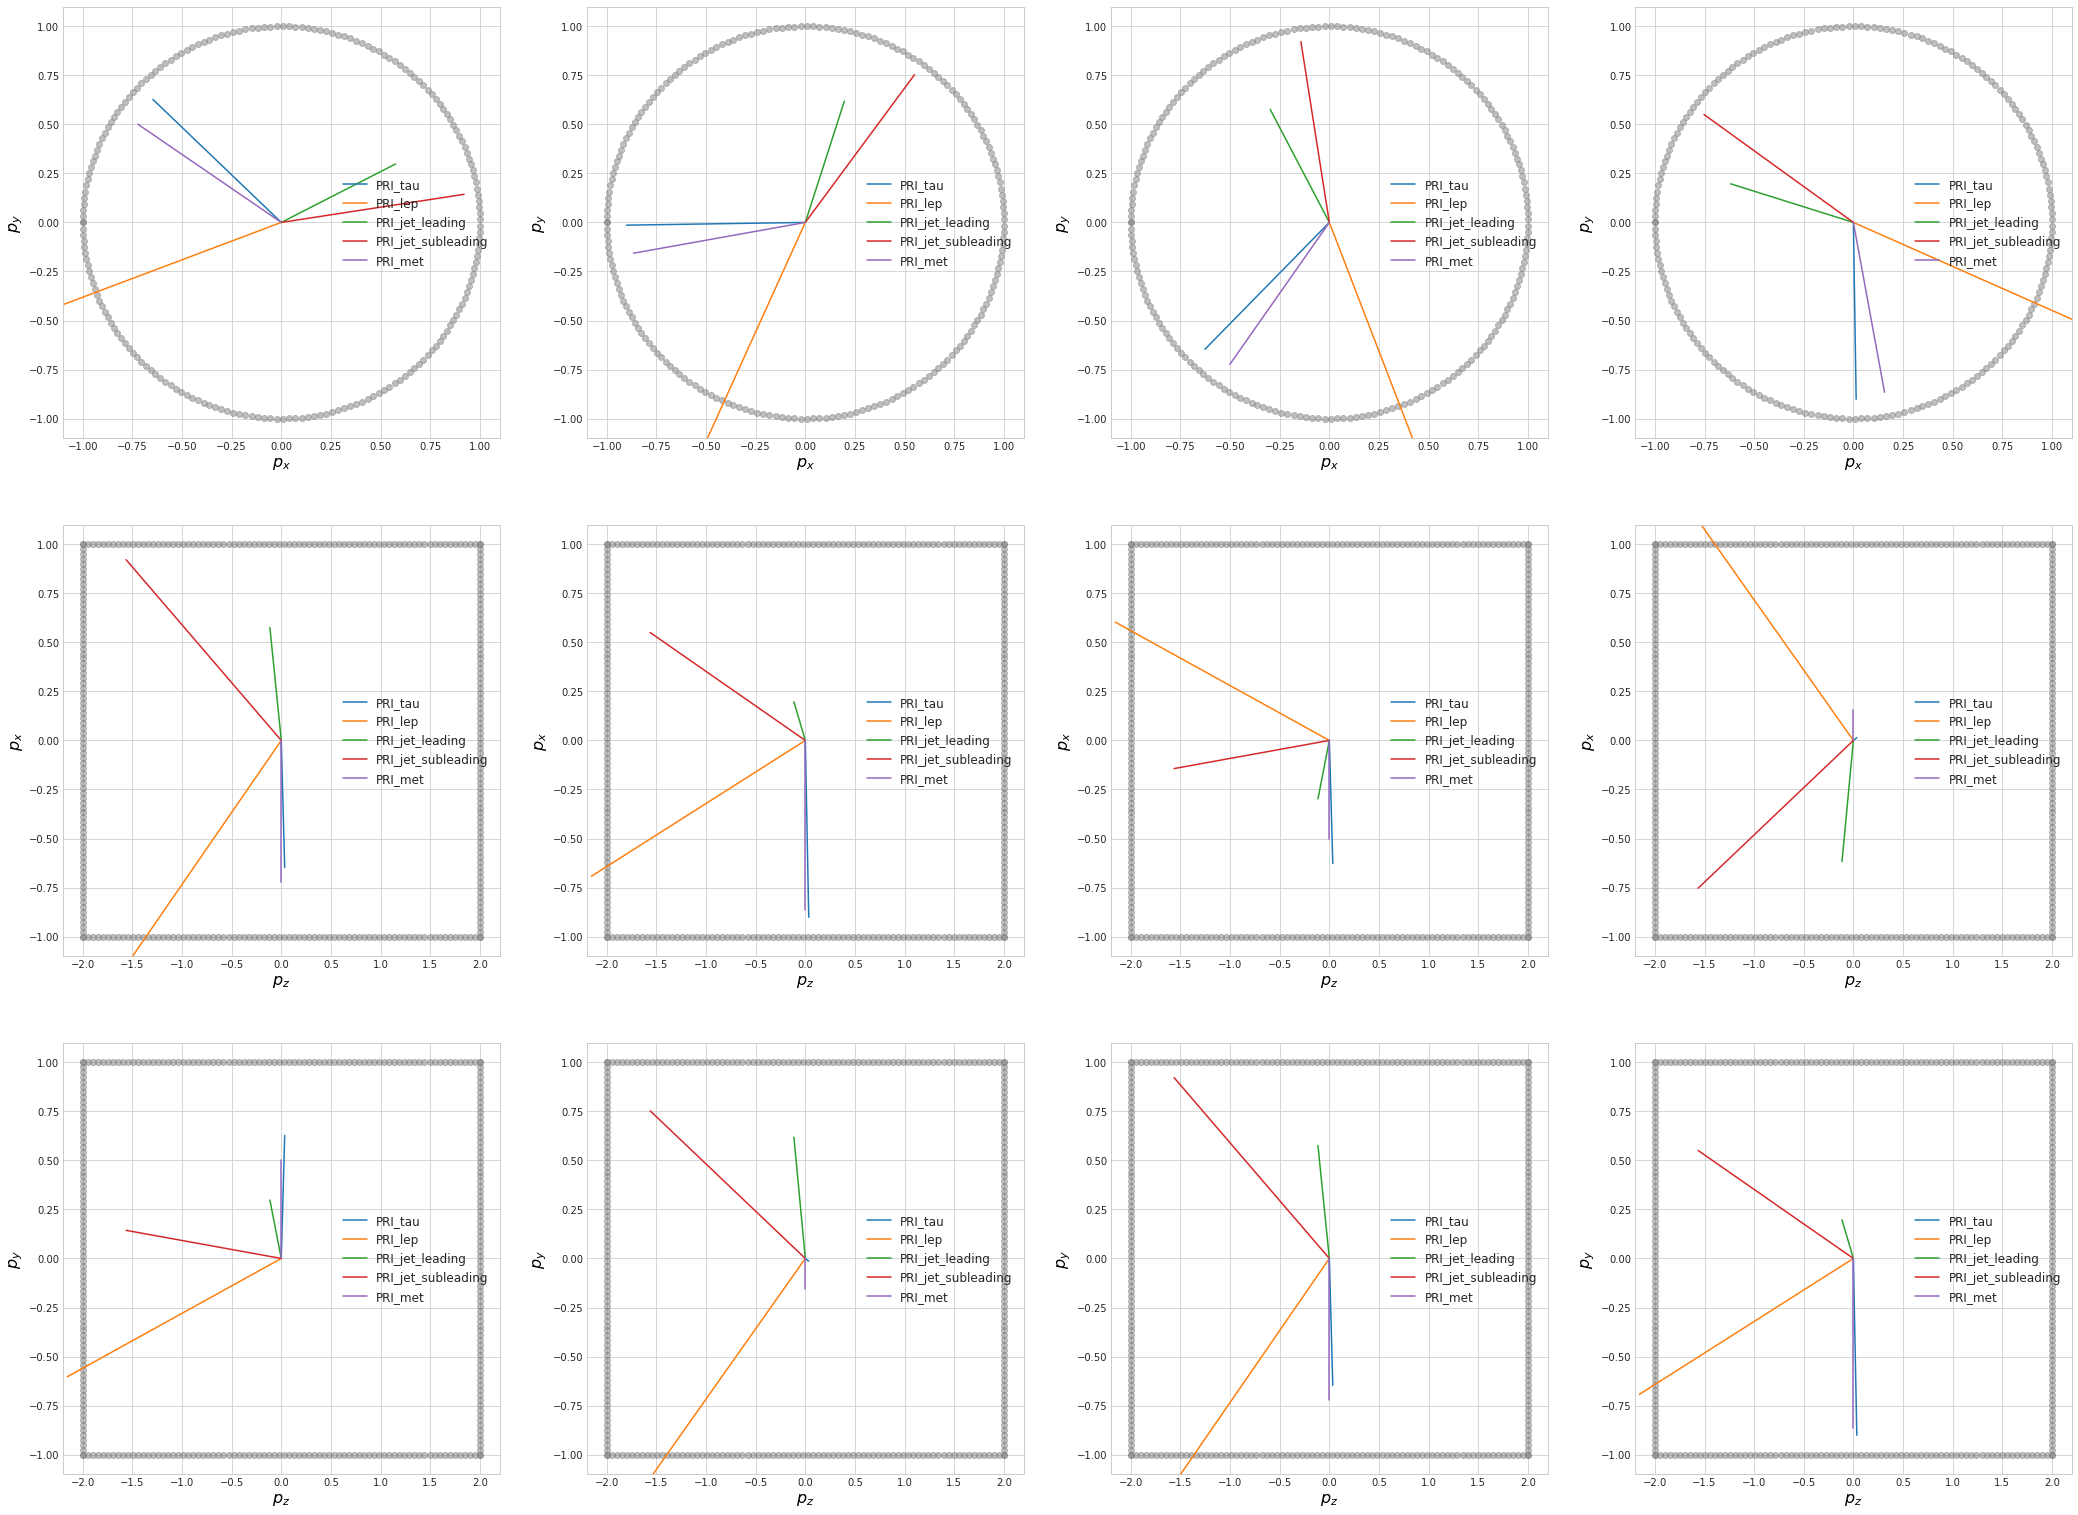

In [5]:
id=3
aug_ranges = [range(4), range(4,8)]
for aug_range in aug_ranges:
    comp_events([pd.DataFrame(train_fy.get_test_fold(0, i)['inputs'], columns=train_feats)[id:id+1] for i in aug_range])

## Determine LR

2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 18.122s 


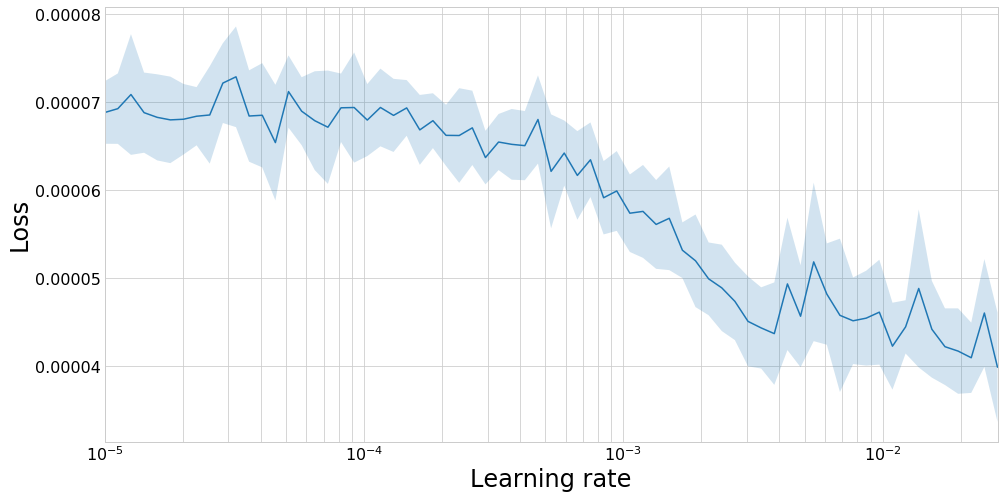

______________________________________



In [6]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [7]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':2e-3}}
use_callbacks = {'CosAnnealLR':{'cycle_mult':2, 'reverse':False, 'redux_decay':True}}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

Training using weights
Training model 1 / 10
Using cosine LR annealing
2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237648). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119214). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 4.1059928525321505e-05
2 New best found: 3.67519157721624e-05
Saving snapshot 2
3 New best found: 3.6029105821889497e-05
4 New best found: 3.544678578333042e-05
5 New best found: 3.456652679497633e-05
6 New best found: 3.414276907558829e-05
Saving snapshot 3
7 New best found: 3.400432980270183e-05
11 New best found: 3.3630520422332326e-05
12 New best found: 3.324470444127178e-05
13 New best found: 3.308725790551754e-05
14 New best found: 3.3002947381846624e-05
Saving snapshot 4
15 New best found: 3.2933779559951874e-05
23 New best found: 3.28581299095232e-05
24 New best found: 3.278827360018468e-05
25 New best found: 3.262071358439663e-05
27 New best found: 3.2573226642828014e-05
28 New best found: 3.2551592784910534e-05
29 New best found: 3.2462442958671955e-05
30 New best found: 3.242518533353664e-05
Saving snapshot 5
31 New best found: 3.242235692743823e-05
49 New best found: 3.232670938472694e-05
50 New best found: 3.217889306356903e-05
55 New be

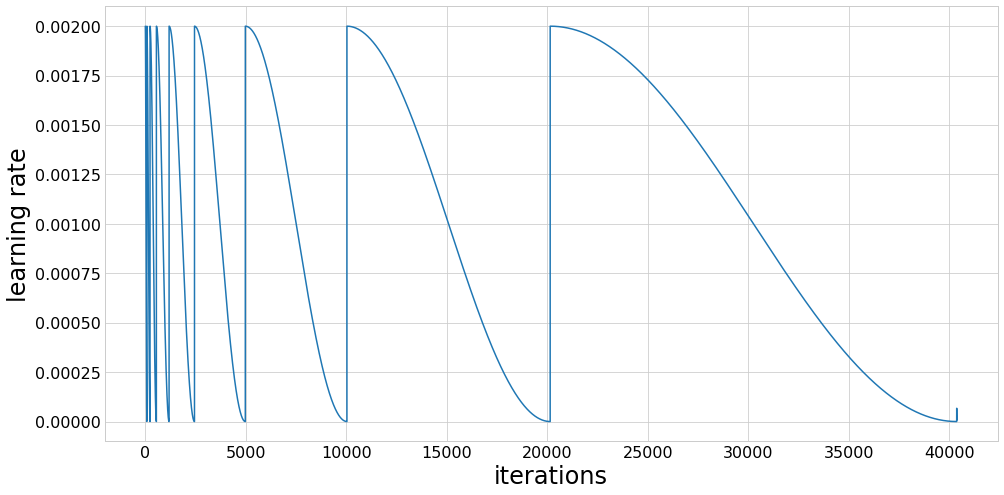

Fold took 573.308s

Training model 2 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.250963). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125892). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 4.210659680829849e-05
2 New best found: 3.716775991342729e-05
Saving snapshot 2
3 New best found: 3.629952022456564e-05
4 New best found: 3.573372820683289e-05
5 New best found: 3.5551276219484865e-05
6 New best found: 3.456347184401238e-05
Saving snapshot 3
7 New best found: 3.442395638558082e-05
9 New best found: 3.4358066842833066e-05
10 New best found: 3.406449176254682e-05
11 New best found: 3.378571808134438e-05
12 New best found: 3.3705291543446946e-05
13 New best found: 3.340104453600361e-05
14 New best found: 3.331721607319196e-05
Saving snapshot 4
15 New best found: 3.330189787593554e-05
21 New best found: 3.311671667761402e-05
22 New best found: 3.3012169858557173e-05
24 New best found: 3.2928449126484335e-05
25 New best found: 3.2659900466387625e-05
26 New best found: 3.2618347823881776e-05
27 New best found: 3.261741230962798e-05
28 New best found: 3.25995136750862e-05
29 New best found: 3.249262209865265e-05
Saving snapshot 5
43 New bes

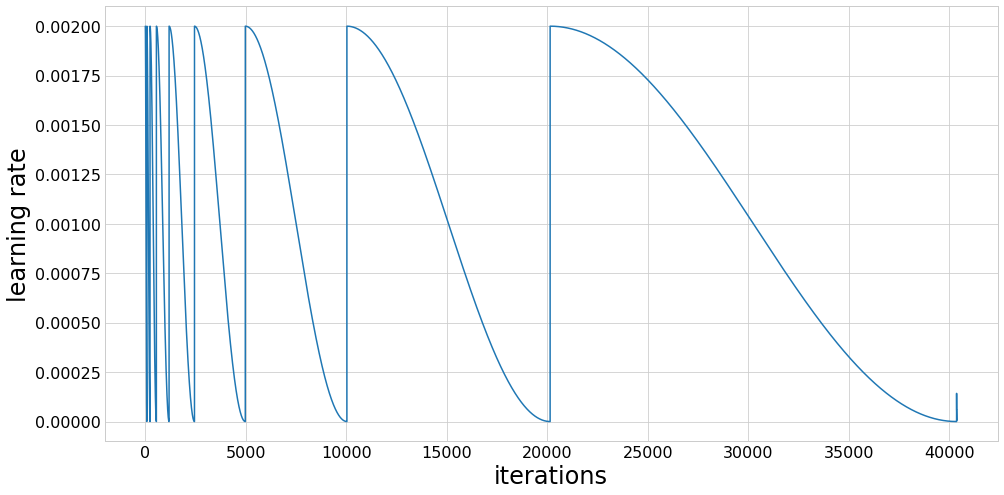

Fold took 581.234s

Training model 3 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.280471). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140645). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 4.139436016901845e-05
2 New best found: 3.659649936341402e-05
Saving snapshot 2
3 New best found: 3.5875382972165934e-05
4 New best found: 3.5737911274009174e-05
5 New best found: 3.5245419871627076e-05
6 New best found: 3.448666014683865e-05
Saving snapshot 3
7 New best found: 3.439780217102193e-05
10 New best found: 3.428457093230493e-05
11 New best found: 3.424124864827544e-05
12 New best found: 3.369287205743602e-05
13 New best found: 3.3620355306102784e-05
14 New best found: 3.349513696163907e-05
Saving snapshot 4
15 New best found: 3.3447446080213715e-05
22 New best found: 3.3255903839155354e-05
26 New best found: 3.2974894742337986e-05
27 New best found: 3.29336145210568e-05
28 New best found: 3.28071836018196e-05
29 New best found: 3.278984283692934e-05
30 New best found: 3.277889566871029e-05
Saving snapshot 5
31 New best found: 3.277611791316945e-05
47 New best found: 3.2687155379771e-05
49 New best found: 3.263326494123907e-05
51 New best 

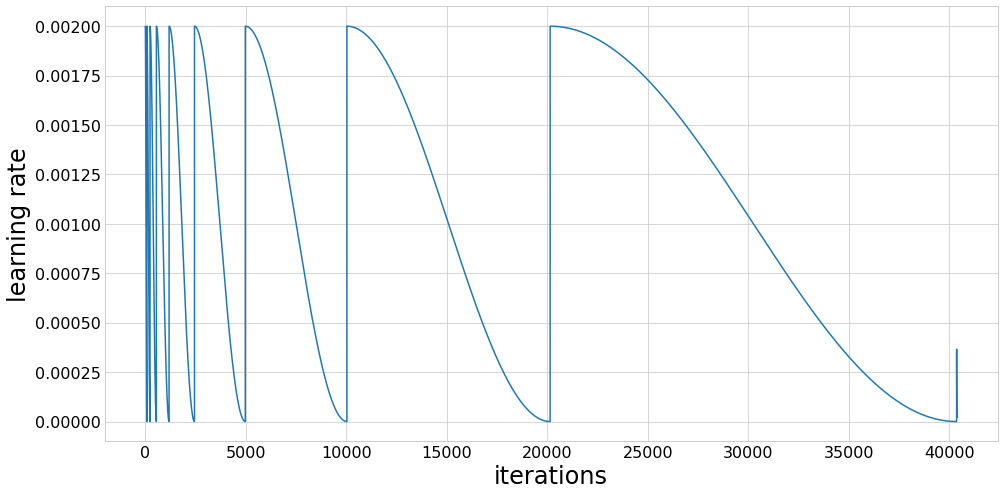

Fold took 585.028s

Training model 4 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.305708). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153324). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 4.161061130412089e-05
2 New best found: 3.710666293733846e-05
Saving snapshot 2
3 New best found: 3.621258733714281e-05
4 New best found: 3.565259903385587e-05
5 New best found: 3.501994391151742e-05
6 New best found: 3.450861549017599e-05
Saving snapshot 3
7 New best found: 3.418926468876045e-05
11 New best found: 3.40426678734351e-05
12 New best found: 3.3822332399620425e-05
13 New best found: 3.3820925314950995e-05
14 New best found: 3.341525284645512e-05
Saving snapshot 4
24 New best found: 3.3404241457442345e-05
25 New best found: 3.3215176843857916e-05
26 New best found: 3.307002007193659e-05
28 New best found: 3.2998127824304796e-05
29 New best found: 3.2997412764826614e-05
30 New best found: 3.295801859752266e-05
Saving snapshot 5
51 New best found: 3.28767551405945e-05
54 New best found: 3.282393258121112e-05
55 New best found: 3.28134419470629e-05
56 New best found: 3.277688617033466e-05
58 New best found: 3.273347535226855e-05
Saving snaps

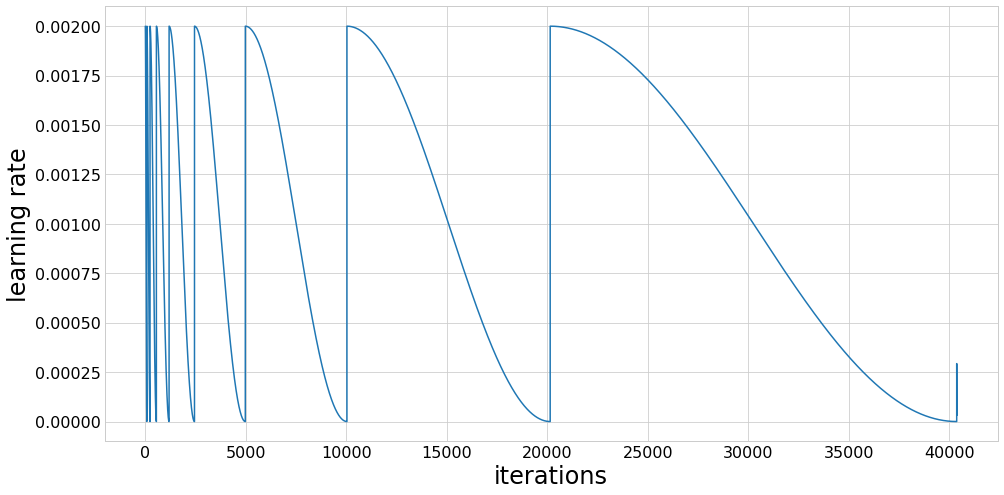

Fold took 588.614s

Training model 5 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.326344). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.163597). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 3.9520817363518293e-05
2 New best found: 3.5926142396056095e-05
Saving snapshot 2
3 New best found: 3.519400550721912e-05
4 New best found: 3.495492463116534e-05
5 New best found: 3.442731419199845e-05
6 New best found: 3.377051371935522e-05
Saving snapshot 3
7 New best found: 3.363724574301159e-05
11 New best found: 3.342035137611674e-05
12 New best found: 3.335626064363169e-05
13 New best found: 3.3047957230883185e-05
14 New best found: 3.297727428289363e-05
Saving snapshot 4
15 New best found: 3.2935861889563967e-05
22 New best found: 3.293470866919961e-05
25 New best found: 3.25545649509877e-05
27 New best found: 3.2511714573774956e-05
28 New best found: 3.241965014458401e-05
30 New best found: 3.24163275261526e-05
Saving snapshot 5
31 New best found: 3.2415313286765013e-05
46 New best found: 3.2383008682518264e-05
48 New best found: 3.237294961872976e-05
49 New best found: 3.234734463330824e-05
51 New best found: 3.2242217476596126e-05
52 New be

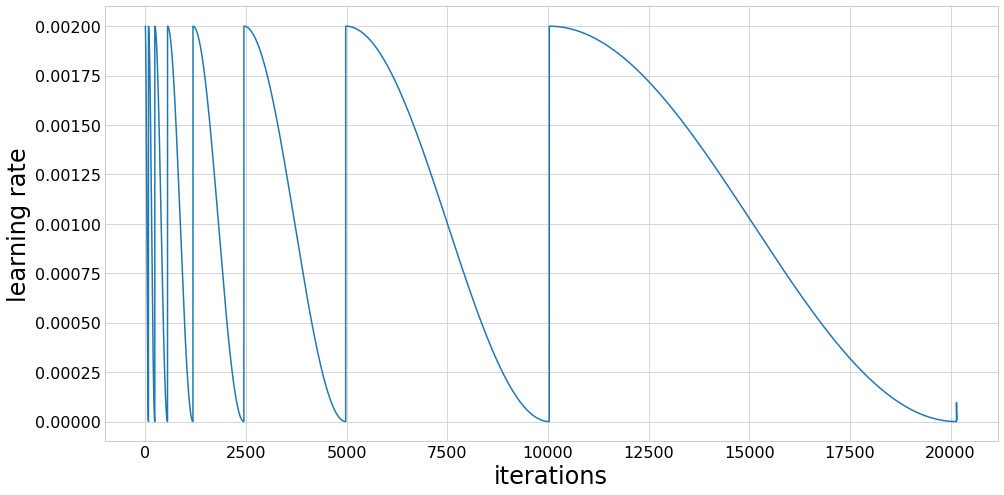

Fold took 303.881s

Training model 6 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.359553). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.180221). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 3.9762800718017386e-05
2 New best found: 3.757278695120476e-05
Saving snapshot 2
3 New best found: 3.6285750860406555e-05
5 New best found: 3.546825125231407e-05
6 New best found: 3.4924775717081505e-05
Saving snapshot 3
7 New best found: 3.46946596793714e-05
10 New best found: 3.4645931517297866e-05
11 New best found: 3.430798138870159e-05
13 New best found: 3.393642897863174e-05
14 New best found: 3.371142824471462e-05
Saving snapshot 4
15 New best found: 3.370632112055318e-05
25 New best found: 3.32949237752473e-05
27 New best found: 3.32347759991535e-05
28 New best found: 3.319959022046533e-05
29 New best found: 3.3168133918661626e-05
30 New best found: 3.315031905513024e-05
Saving snapshot 5
31 New best found: 3.314648687519366e-05
41 New best found: 3.3120857195171996e-05
46 New best found: 3.309947378147626e-05
47 New best found: 3.3045990619575606e-05
49 New best found: 3.302598421723815e-05
50 New best found: 3.291452630801359e-05
52 New bes

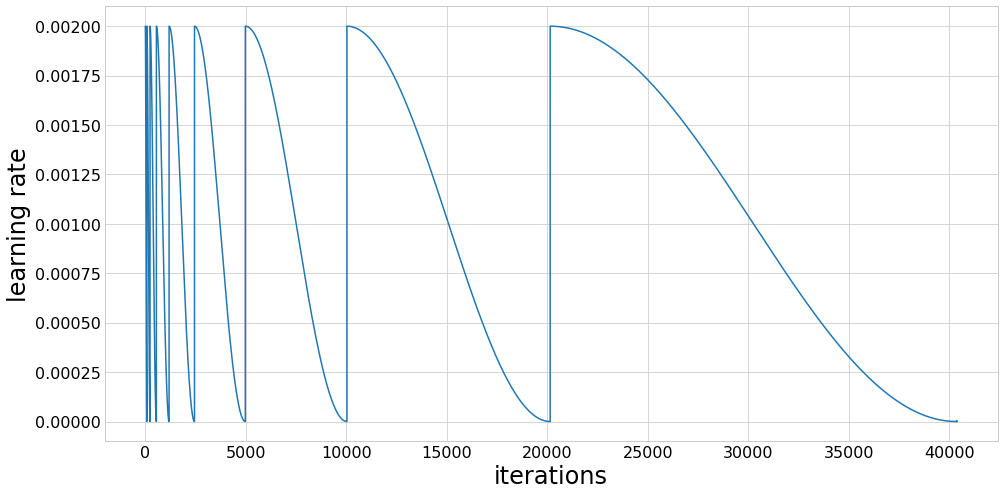

Fold took 599.592s

Training model 7 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.397619). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.199220). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 3.9624866534063436e-05
2 New best found: 3.587453249428195e-05
Saving snapshot 2
3 New best found: 3.5338901798266303e-05
4 New best found: 3.5051628588629194e-05
5 New best found: 3.437343319099375e-05
6 New best found: 3.380338235757459e-05
Saving snapshot 3
7 New best found: 3.358924121974488e-05
10 New best found: 3.3463598534737175e-05
11 New best found: 3.319214731335833e-05
12 New best found: 3.298234016714218e-05
13 New best found: 3.273579295128027e-05
14 New best found: 3.254816148265091e-05
Saving snapshot 4
15 New best found: 3.253902107513665e-05
24 New best found: 3.238760709414938e-05
25 New best found: 3.226200858707321e-05
26 New best found: 3.219416073905204e-05
28 New best found: 3.210750295529178e-05
29 New best found: 3.208165143120541e-05
30 New best found: 3.2052669465359556e-05
Saving snapshot 5
31 New best found: 3.2048323755623414e-05
49 New best found: 3.186658315882048e-05
52 New best found: 3.180574515197351e-05
55 New be

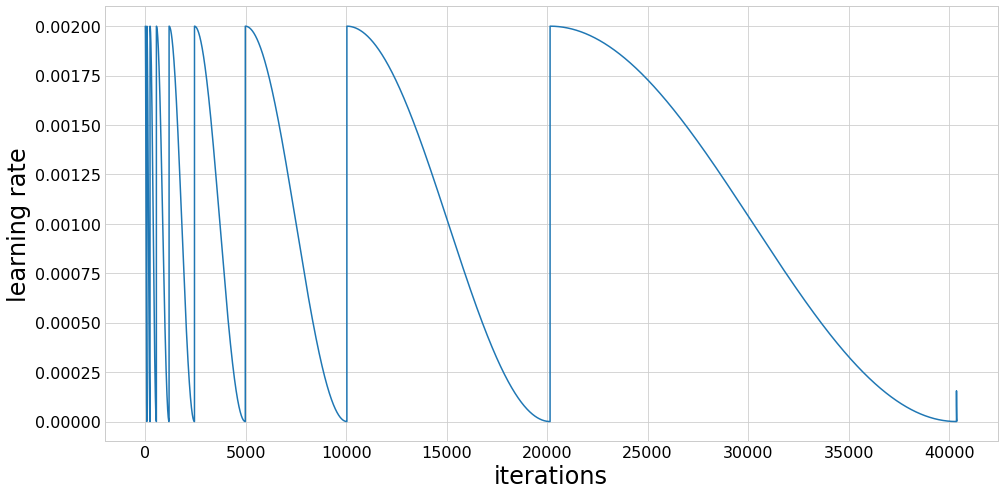

Fold took 620.429s

Training model 8 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.402329). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.201647). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 4.126366768034219e-05
2 New best found: 3.640770397986973e-05
Saving snapshot 2
3 New best found: 3.579190961258061e-05
5 New best found: 3.464209956270132e-05
6 New best found: 3.417523325908179e-05
Saving snapshot 3
7 New best found: 3.392594923960461e-05
10 New best found: 3.36615945692137e-05
11 New best found: 3.358131391410664e-05
12 New best found: 3.30988257648548e-05
13 New best found: 3.305260259862213e-05
14 New best found: 3.304589506014367e-05
Saving snapshot 4
15 New best found: 3.2985635538071785e-05
23 New best found: 3.286264009952487e-05
24 New best found: 3.268883510164836e-05
25 New best found: 3.257852900467044e-05
26 New best found: 3.257018636980467e-05
27 New best found: 3.244907543729614e-05
28 New best found: 3.237343537633148e-05
30 New best found: 3.2367322615917884e-05
Saving snapshot 5
31 New best found: 3.236125527812272e-05
48 New best found: 3.227215061155451e-05
52 New best found: 3.214643677715813e-05
54 New best fo

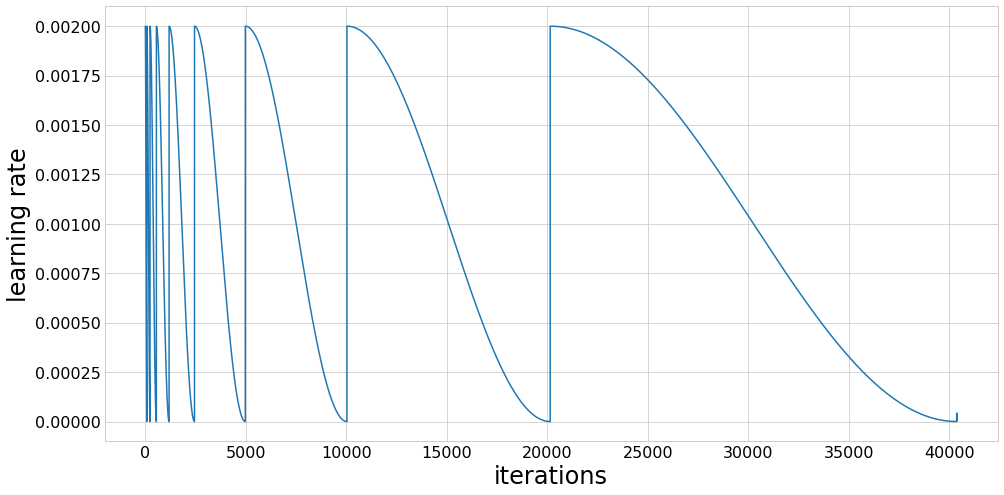

Fold took 619.219s

Training model 9 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.461899). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231353). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 4.176334627118195e-05
2 New best found: 3.6615727965545375e-05
Saving snapshot 2
3 New best found: 3.590056665998418e-05
5 New best found: 3.4874967430368994e-05
6 New best found: 3.4392132586799564e-05
Saving snapshot 3
7 New best found: 3.4253334924869704e-05
11 New best found: 3.385042766458355e-05
12 New best found: 3.379888718336588e-05
13 New best found: 3.361628298007417e-05
14 New best found: 3.337075537856435e-05
Saving snapshot 4
15 New best found: 3.3300552726723253e-05
23 New best found: 3.3262975672550965e-05
24 New best found: 3.2965140428859744e-05
27 New best found: 3.2948665392177647e-05
28 New best found: 3.27974744795938e-05
29 New best found: 3.274493482604157e-05
30 New best found: 3.2743151587783356e-05
Saving snapshot 5
31 New best found: 3.2734342486946845e-05
50 New best found: 3.245746356114978e-05
51 New best found: 3.242483984358842e-05
56 New best found: 3.24020717132953e-05
58 New best found: 3.2372776452393735e-05
59 Ne

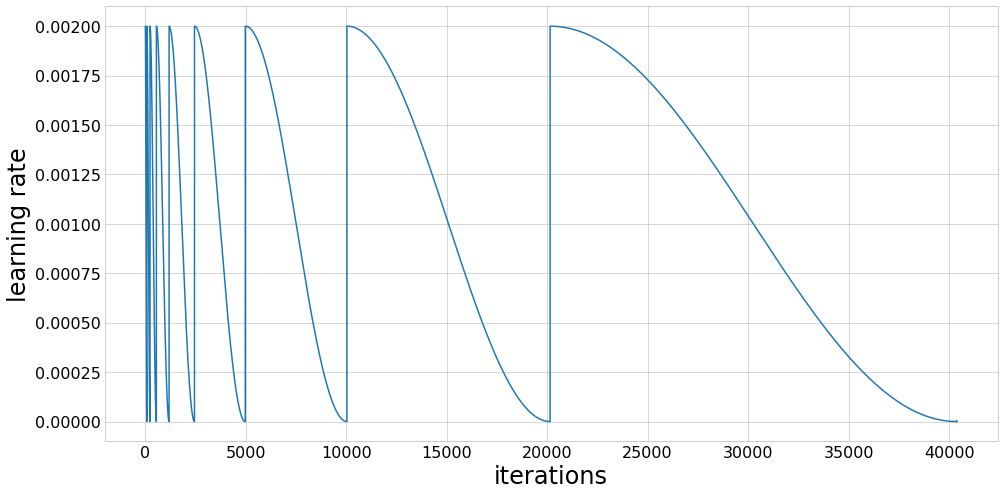

Fold took 629.857s

Training model 10 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.474442). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237608). Check your callbacks.
  % delta_t_median)


Saving snapshot 1
1 New best found: 3.992944298217483e-05
2 New best found: 3.6189151864535286e-05
Saving snapshot 2
3 New best found: 3.5633299095208055e-05
5 New best found: 3.4967896455380935e-05
6 New best found: 3.420415771918545e-05
Saving snapshot 3
7 New best found: 3.407290119893896e-05
10 New best found: 3.3942858710965644e-05
12 New best found: 3.344670540361382e-05
13 New best found: 3.3243983555131085e-05
14 New best found: 3.3172759720713104e-05
Saving snapshot 4
15 New best found: 3.3149204441024694e-05
24 New best found: 3.298835455988689e-05
25 New best found: 3.28611485868192e-05
27 New best found: 3.2788148916671974e-05
28 New best found: 3.2698394731512875e-05
29 New best found: 3.266757233693576e-05
30 New best found: 3.2638196058732036e-05
Saving snapshot 5
31 New best found: 3.263349576367388e-05
47 New best found: 3.258837989807815e-05
50 New best found: 3.251206881854118e-05
51 New best found: 3.242107964933765e-05
54 New best found: 3.23420854523012e-05
55 New

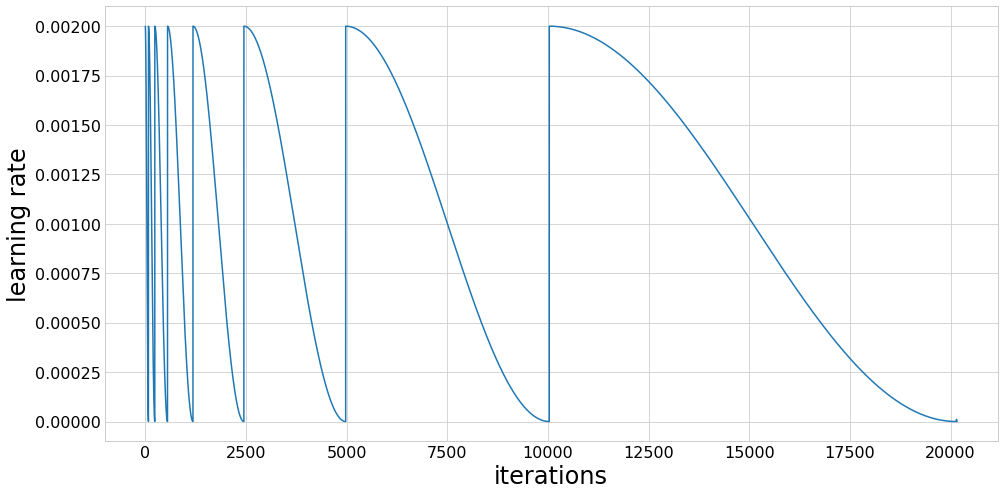

Fold took 320.492s


______________________________________
Training finished
Cross-validation took 5421.858s 


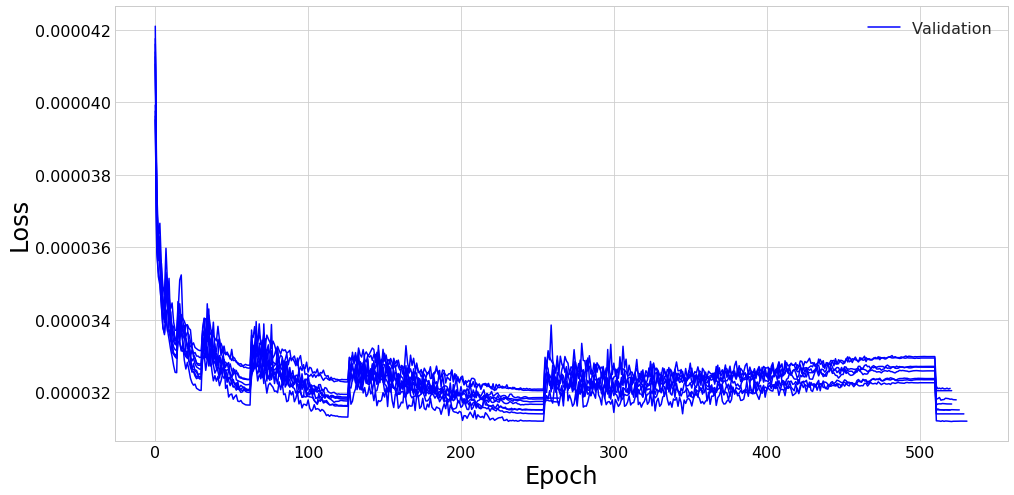

Mean loss = 3.167e-05 +- 8e-08
Mean wAUC = 0.0628 +- 0.0003
Mean AUC = 0.0979 +- 0.0005
Mean AMS = 3.93 +- 0.06
Mean cut = 0.956 +- 0.007
______________________________________



<Figure size 432x288 with 0 Axes>

In [8]:
results, histories, cycle_losses = fold_train_model(train_fy, n_models,
                                                    model_gen_params=model_gen_params,
                                                    train_params=train_params, train_on_weights=True,
                                                    use_callbacks=use_callbacks, ams_args=ams_args,
                                                    max_epochs=max_epochs, patience=patience,
                                                    verbose=1, plots=plots)

## Construct ensemble

In [4]:
with open('train_weights/results_file.pkl', 'rb') as fin:   
    results = pickle.load(fin)
with open('train_weights/cycle_file.pkl', 'rb') as fin:   
    cycle_losses = pickle.load(fin)

In [5]:
ensemble, weights = assemble_ensemble(results, 10, ensemble_mode, compile_args, weighting='reciprocal')


Choosing ensemble by loss
Model 0 is 6 with loss = 3.1190115495387144e-05


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Model 1 is 8 with loss = 3.140091588429641e-05
Model 2 is 1 with loss = 3.1504884691094046e-05


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Model 3 is 7 with loss = 3.150896259716113e-05
Model 4 is 0 with loss = 3.1649064098109376e-05


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Model 5 is 4 with loss = 3.171805411111564e-05
Model 6 is 2 with loss = 3.177953626190423e-05


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Model 7 is 9 with loss = 3.1835723633528746e-05


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Model 8 is 5 with loss = 3.204131573147606e-05
Model 9 is 3 with loss = 3.204502579458101e-05


In [11]:
def test_ensemble(weighting, size, rot_mult):
    ensemble, weights = assemble_ensemble(results, size, ensemble_mode, compile_args, weighting=weighting, verbose=0)
    val_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'val.hdf5', "r+"), rot_mult=rot_mult)
    fold_ensemble_predict(ensemble, weights, val_fy, pred_name='pred_TTA', ensemble_size=ensemble_size, verbose=0)
    val_df_tta = convert_to_df(val_fy.source, pred_name='pred_TTA')
    ams, cut = ams_scan_slow(val_df_tta, br=10, w_factor=250000/50000)
    print(weighting, size, rot_mult, ams, cut)

In [12]:
for weighting in ['reciprocal', 'uniform']:
    for size in [1,3,5,10]:
        for rot_mult in [1,2,4,8,16]:
            print('__________________________________')
            test_ensemble(weighting, size, rot_mult)
            print('__________________________________\n')

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 4
50000 candidates loaded
reciprocal 1 1 3.788911537800028 0.9467519
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8
50000 candidates loaded
reciprocal 1 2 3.8841733218132775 0.96165144
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 16
50000 candidates loaded
reciprocal 1 4 3.8958360376082917 0.9611604
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 32
50000 candidates loaded
reciprocal 1 8 3.868675617122736 0.96116006
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 64
50000 candidates loaded
reciprocal 1 16 3.880195682869566 0.9611739
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 4
50000 candidates loaded
reciprocal 3 1 3.9256678698853507 0.9593204
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8
50000 candidates loaded
reciprocal 3 2 3.9644529913660382 0.962972
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 16
50000 candidates loaded
reciprocal 3 4 3.9365058289398327 0.9627416
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 32
50000 candidates loaded
reciprocal 3 8 3.935727490426795 0.96295184
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 64
50000 candidates loaded
reciprocal 3 16 3.948642406826559 0.9633027
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anac

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 4
50000 candidates loaded
reciprocal 5 1 3.8996097692061755 0.95961064
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anac

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8
50000 candidates loaded
reciprocal 5 2 3.9184082455718023 0.96238965
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anac

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 16
50000 candidates loaded
reciprocal 5 4 3.90644781285902 0.962022
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anac

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 32
50000 candidates loaded
reciprocal 5 8 3.9149331520865527 0.96115786
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anac

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 64
50000 candidates loaded
reciprocal 5 16 3.9186895127476875 0.96114445
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anac

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 4
50000 candidates loaded
reciprocal 10 1 3.914418756570967 0.9613416
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anac

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8
50000 candidates loaded
reciprocal 10 2 3.9449610621791713 0.9603574
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anac

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 16
50000 candidates loaded
reciprocal 10 4 3.9564414878636986 0.9603923
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anac

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 32
50000 candidates loaded
reciprocal 10 8 3.9510233504692396 0.9602919
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anac

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 64
50000 candidates loaded
reciprocal 10 16 3.947876304943562 0.9605243
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 4
50000 candidates loaded
uniform 1 1 3.788911537800028 0.9467519
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8
50000 candidates loaded
uniform 1 2 3.8841733218132775 0.96165144
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 16
50000 candidates loaded
uniform 1 4 3.8958360376082917 0.9611604
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 32
50000 candidates loaded
uniform 1 8 3.868675617122736 0.96116006
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 64
50000 candidates loaded
uniform 1 16 3.880195682869566 0.9611739
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 4
50000 candidates loaded
uniform 3 1 3.9255183896007835 0.9593173
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8
50000 candidates loaded
uniform 3 2 3.9641474718534497 0.9630047
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 16
50000 candidates loaded
uniform 3 4 3.932236900147388 0.9627705
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 32
50000 candidates loaded
uniform 3 8 3.937891453676422 0.96293324
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 64
50000 candidates loaded
uniform 3 16 3.9488059682882004 0.9633061
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anac

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 4
50000 candidates loaded
uniform 5 1 3.9016787620903637 0.9592562
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anac

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8
50000 candidates loaded
uniform 5 2 3.91659566204658 0.9623558
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anac

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 16
50000 candidates loaded
uniform 5 4 3.9055188820122932 0.9620017
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anac

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 32
50000 candidates loaded
uniform 5 8 3.9149331520865527 0.96116036
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anac

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 64
50000 candidates loaded
uniform 5 16 3.920471459589865 0.96115464
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anac

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 4
50000 candidates loaded
uniform 10 1 3.9166885038531887 0.9613804
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anac

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8
50000 candidates loaded
uniform 10 2 3.944530771457362 0.9603704
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anac

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 16
50000 candidates loaded
uniform 10 4 3.9601670308140546 0.9603743
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anac

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 32
50000 candidates loaded
uniform 10 8 3.9510233504692396 0.96029395
__________________________________

__________________________________


/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anaconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/giles/anac

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 64
50000 candidates loaded
uniform 10 16 3.947876304943562 0.96052945
__________________________________



## Response on validation data without TTA

In [ ]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [ ]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

In [ ]:
val_df = convert_to_df(val_fy.source)

In [ ]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df.gen_target, val_df.pred_class),
                                                           roc_auc_score(val_df.gen_target, val_df.pred_class, sample_weight=val_df.gen_weight)))

In [ ]:
%%time
cut_kde = kde_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

In [ ]:
%%time
cut_mean = mean_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

## Response on validation data with TTA

In [16]:
val_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'val.hdf5', "r+"), rot_mult=3, random_rot=True)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 12


In [17]:
fold_ensemble_predict(ensemble, weights, val_fy, pred_name='pred_TTA', ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0026336687557399273s per sample

Predicting fold 2 out of 10
Prediction took 0.002646856793016195s per sample

Predicting fold 3 out of 10
Prediction took 0.002665128621459007s per sample

Predicting fold 4 out of 10
Prediction took 0.002679678378999233s per sample

Predicting fold 5 out of 10
Prediction took 0.002641610548645258s per sample

Predicting fold 6 out of 10
Prediction took 0.0026639858938753607s per sample

Predicting fold 7 out of 10
Prediction took 0.002652420435845852s per sample

Predicting fold 8 out of 10
Prediction took 0.002677889174968004s per sample

Predicting fold 9 out of 10
Prediction took 0.0026962500512599944s per sample

Predicting fold 10 out of 10
Prediction took 0.0026486395575106144s per sample



In [18]:
val_df_tta = convert_to_df(val_fy.source, pred_name='pred_TTA')

50000 candidates loaded


In [19]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df_tta.gen_target, val_df_tta.pred_class),
                                                           roc_auc_score(val_df_tta.gen_target, val_df_tta.pred_class, sample_weight=val_df_tta.gen_weight)))

Testing ROC AUC: unweighted 0.9038728135790862, weighted 0.93631538752653


Best cut at 0.9650544422166841 corresponds to AMS of 3.796564851412063
Maximum AMS for data is 3.952682637539464 at cut of 0.9604984521865845
CPU times: user 27 s, sys: 0 ns, total: 27 s
Wall time: 27 s


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


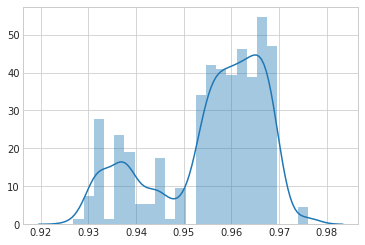

In [20]:
%%time
cut_kde_tta = kde_optimise_cut(val_df_tta, top_perc=0.05, br=10, w_factor=250000/50000)

Mean cut at 0.95576096 corresponds to AMS of 3.8274904155283145
Maximum AMS for data is 3.952682637539464 at cut of 0.9604984521865845
CPU times: user 108 ms, sys: 0 ns, total: 108 ms
Wall time: 106 ms


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


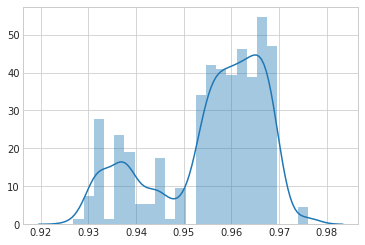

In [21]:
%%time
cut_mean_tta = mean_optimise_cut(val_df_tta, top_perc=0.05, br=10, w_factor=250000/50000)

# Test scoring - Without TTA

In [ ]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [ ]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

In [ ]:
score_test_data(test_fy.source, cut_kde)

In [ ]:
score_test_data(test_fy.source, cut_mean)

# Test scoring - With TTA

In [22]:
test_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'testing.hdf5', "r+"),
                            rot_mult=3, random_rot=True)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 12


In [23]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, pred_name='pred_TTA', ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0025911448367617346s per sample

Predicting fold 2 out of 10
Prediction took 0.0031903518545356663s per sample

Predicting fold 3 out of 10
Prediction took 0.002487852730331096s per sample

Predicting fold 4 out of 10
Prediction took 0.002489928487214175s per sample

Predicting fold 5 out of 10
Prediction took 0.0024927269500087607s per sample

Predicting fold 6 out of 10
Prediction took 0.002491637842763554s per sample

Predicting fold 7 out of 10
Prediction took 0.002507823293791576s per sample

Predicting fold 8 out of 10
Prediction took 0.002491593166643923s per sample

Predicting fold 9 out of 10
Prediction took 0.002511139623888514s per sample

Predicting fold 10 out of 10
Prediction took 0.002497240414470434s per sample

CPU times: user 27min 59s, sys: 2min 50s, total: 30min 49s
Wall time: 23min 36s


In [24]:
score_test_data(test_fy.source, cut_kde_tta, pred_name='pred_TTA')

Public:Private AMS: 3.605880122590875 : 3.755655471688215


(3.605880122590875, 3.755655471688215)

In [25]:
score_test_data(test_fy.source, cut_mean_tta, pred_name='pred_TTA')

Public:Private AMS: 3.8524044887812843 : 3.823531863618695


(3.8524044887812843, 3.823531863618695)

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)